In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms, models
import local_helper

%matplotlib inline

# Fruits 360 w/ PyTorch and FastAI

In [2]:
# load data
img_size = 224

# local
#train_dir = '../data/fruits/data/train/'
#test_dir = '../data/fruits/data/test/'

# floyd
train_dir = '../input/fruits/training/'
test_dir = '../input/fruits/test/'

train_transforms = transforms.Compose([
    
    # resize image
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    
    # augment
    #transforms.RandomRotation(45),
    #transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    
    # convert to tensor and normalize
    transforms.ToTensor(),
    #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    
    # resize image
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    
    # convert to tensor and normalize
    transforms.ToTensor(),
    #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

])

train = datasets.ImageFolder(root = train_dir, transform = train_transforms)
test = datasets.ImageFolder(root = test_dir, transform = test_transforms)

In [16]:
train

Dataset ImageFolder
    Number of datapoints: 41322
    Root Location: ../input/fruits/training/
    Transforms (if any): Compose(
                             Resize(size=224, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(224, 224))
                             RandomHorizontalFlip(p=0.5)
                             RandomVerticalFlip(p=0.5)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

In [17]:
test

Dataset ImageFolder
    Number of datapoints: 13877
    Root Location: ../input/fruits/test/
    Transforms (if any): Compose(
                             Resize(size=224, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(224, 224))
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

In [18]:
trainloader = torch.utils.data.DataLoader(dataset = train, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(dataset = test, batch_size = 64, shuffle = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


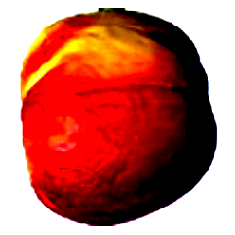

In [19]:
# Run this to test your data loader
images, labels = next(iter(trainloader))
local_helper.imshow(images[0], normalize=False);

In [20]:
#model = models.densenet121(pretrained = True)
model = models.resnet34(pretrained = True)
#model

In [21]:
# new final layer with 16 classes
num_ftrs = model.fc.in_features

model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [22]:
# freeze the rest of the layers
for param in model.parameters():
    param.requires_grad = False

In [23]:
# create new classifier for the fruits dataset
classifier = nn.Sequential(
    OrderedDict([
        ('fc1', nn.Linear(num_ftrs, 256)),
        ('relu', nn.ReLU()),
        ('fc2', nn.Linear(256, 81)),
        ('output', nn.Softmax(dim = 1))
    ])
)

# add to pre-trained network
model.fc = classifier

In [24]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001)
optimizer = optim.Adam(model.fc.parameters(), lr = 0.001)

In [25]:
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [26]:
# Implement a function for the validation pass
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for inputs, labels in testloader:
        
        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)
        
        # calc test loss
        outputs = model(inputs)
        test_loss += criterion(outputs, labels).item()
        
        # calc accuracy
        ps = torch.argmax(outputs, dim=1)
        equality = (labels.data == ps)
        accuracy += equality.type(torch.cuda.FloatTensor).mean()
    
    return test_loss, accuracy

In [29]:
epochs = 10
#print_steps = 250
#steps = 0

model.to(device)

for epoch in range(epochs):
    
    running_loss = 0
    steps = 0
    model.train()

    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1
        if steps % 100 == 0: print(steps)

        # zero the parameter (weight) gradients
        optimizer.zero_grad()

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # progress
        running_loss += loss.item()

    # make sure model is in eval mode since dropout is being used
    model.eval()

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        test_loss, accuracy = validation(model, testloader, criterion)

    print("Epoch: {}/{}.. ".format(epoch+1, epochs),
          #"Training Loss: {:.3f}.. ".format(running_loss / print_steps),
          "Training Loss: {:.3f}.. ".format(running_loss / steps),
          "Test Loss: {:.3f}.. ".format(test_loss / len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy / len(testloader)))

    running_loss = 0

    # Make sure training is back on
    model.train()

100
200
300
400
500
600
Epoch: 1/10..  Training Loss: 3.665..  Test Loss: 3.672..  Test Accuracy: 0.745
100
200
300
400
500
600
Epoch: 2/10..  Training Loss: 3.663..  Test Loss: 3.671..  Test Accuracy: 0.746
100
200
300
400
500
600
Epoch: 3/10..  Training Loss: 3.659..  Test Loss: 3.665..  Test Accuracy: 0.752
100
200
300
400
500
600
Epoch: 4/10..  Training Loss: 3.653..  Test Loss: 3.660..  Test Accuracy: 0.756
100
200
300
400
500
600
Epoch: 5/10..  Training Loss: 3.651..  Test Loss: 3.651..  Test Accuracy: 0.765
100
200
300
400
500
600
Epoch: 6/10..  Training Loss: 3.635..  Test Loss: 3.626..  Test Accuracy: 0.790
100
200
300
400
500
600
Epoch: 7/10..  Training Loss: 3.612..  Test Loss: 3.618..  Test Accuracy: 0.799
100
200
300
400
500
600
Epoch: 8/10..  Training Loss: 3.607..  Test Loss: 3.612..  Test Accuracy: 0.804
100
200
300
400
500
600
Epoch: 9/10..  Training Loss: 3.607..  Test Loss: 3.613..  Test Accuracy: 0.803
100
200
300
400
500
600
Epoch: 10/10..  Training Loss: 3.607..  

Epoch: 1/3..  Training Loss: 3.996..  Test Loss: 3.876..  Test Accuracy: 0.545

Epoch: 2/3..  Training Loss: 3.853..  Test Loss: 3.849..  Test Accuracy: 0.570

Epoch: 3/3..  Training Loss: 3.824..  Test Loss: 3.819..  Test Accuracy: 0.598

Epoch: 1/7..  Training Loss: 3.811..  Test Loss: 3.811..  Test Accuracy: 0.604

Epoch: 2/7..  Training Loss: 3.794..  Test Loss: 3.778..  Test Accuracy: 0.638

Epoch: 3/7..  Training Loss: 3.774..  Test Loss: 3.770..  Test Accuracy: 0.647

Epoch: 4/7..  Training Loss: 3.748..  Test Loss: 3.731..  Test Accuracy: 0.684

Epoch: 5/7..  Training Loss: 3.728..  Test Loss: 3.732..  Test Accuracy: 0.684

Epoch: 6/7..  Training Loss: 3.704..  Test Loss: 3.693..  Test Accuracy: 0.724

Epoch: 7/7..  Training Loss: 3.680..  Test Loss: 3.667..  Test Accuracy: 0.749

Epoch: 1/10..  Training Loss: 3.665..  Test Loss: 3.672..  Test Accuracy: 0.745

Epoch: 2/10..  Training Loss: 3.663..  Test Loss: 3.671..  Test Accuracy: 0.746

Epoch: 3/10..  Training Loss: 3.659..  Test Loss: 3.665..  Test Accuracy: 0.752

Epoch: 4/10..  Training Loss: 3.653..  Test Loss: 3.660..  Test Accuracy: 0.756

Epoch: 5/10..  Training Loss: 3.651..  Test Loss: 3.651..  Test Accuracy: 0.765

Epoch: 6/10..  Training Loss: 3.635..  Test Loss: 3.626..  Test Accuracy: 0.790

Epoch: 7/10..  Training Loss: 3.612..  Test Loss: 3.618..  Test Accuracy: 0.799

Epoch: 8/10..  Training Loss: 3.607..  Test Loss: 3.612..  Test Accuracy: 0.804

Epoch: 9/10..  Training Loss: 3.607..  Test Loss: 3.613..  Test Accuracy: 0.803

Epoch: 10/10..  Training Loss: 3.607..  Test Loss: 3.619..  Test Accuracy: 0.797

# Fast AI

In [2]:
import warnings
import cv2

from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.metrics import fbeta_score

%reload_ext autoreload
%autoreload 2
torch.cuda.set_device(0)

In [7]:
def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        return max([fbeta_score(targs, (preds>th), 2, average='samples')
                   for th in np.arange(start,end,step)])

def get_1st(path, pattern):
    return glob(f'{path}/*{pattern}.*')[2]

def get_data(sz, batch_size = 64):
    
    # init transforms
    tfms = tfms_from_model(f_model = arch,
                           sz = sz,
                           aug_tfms = transforms_top_down,
                           max_zoom = 1.05)
    
    # init classifier data
    clf_data = ImageClassifierData.from_paths(path = PATH,
                                              trn_name = 'training',
                                              val_name = 'test',
                                              tfms = tfms,
                                              bs = batch_size)
    
    return clf_data

def load_model_new_kernel(model_path, arch = resnet101, sz = 64):
    data = get_data(224)
    data = data.resize(int(sz * 1.3), '/tmp')
    learn = ConvLearner.pretrained(f = arch, data = data)
    learn.load(model_path)
    
    return learn

In [4]:
PATH = '../input/fruits/'
read_path = '../input/fruits/*'
train_dir = '../input/fruits/training/'
test_dir = '../input/fruits/test/'

sz = 224
batch_size = 64
arch = resnet34

In [5]:
ls {PATH}

test/  test-multiple_fruits/  training/


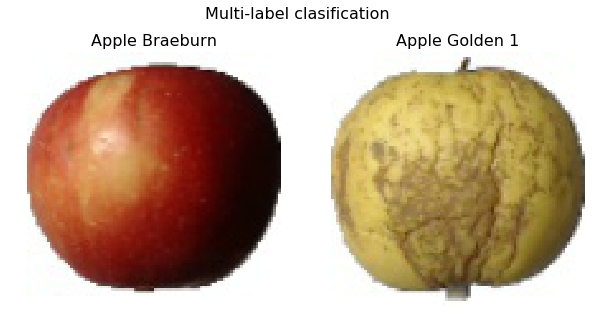

In [8]:
list_paths = [f"{PATH}/training/Apple Braeburn/0_100.jpg",
              f"{PATH}/training/Apple Golden 1/116_100.jpg"]
titles = ["Apple Braeburn", "Apple Golden 1" ]
plots_from_files(list_paths,titles=titles,maintitle="Multi-label clasification")

In [9]:
# set metrics and architecture
metrics = [f2]
arch = resnet34

# import the training dataset
training_fruit_img = []
training_label = []

for dir_path in glob(train_dir+'*'):
    img_label = dir_path.split("/")[-1]
    
    for img_path in glob(os.path.join(dir_path, "*.jpg")):
        img = cv2.imread(img_path)
        training_fruit_img.append(img)
        training_label.append(img_label)

training_fruit_img = np.array(training_fruit_img)
training_label = np.array(training_label)
print('n labels:', len(np.unique(training_label)))

n labels: 81


In [10]:
label_to_id_dict = {v:i for i,v in enumerate(np.unique(training_label))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}

for i, (k, v) in enumerate(label_to_id_dict.items()):
    print(k, ':', v)
    if i == 5: break

Apple Braeburn : 0
Apple Golden 1 : 1
Apple Golden 2 : 2
Apple Golden 3 : 3
Apple Granny Smith : 4
Apple Red 1 : 5


In [11]:
label_ids = np.array([label_to_id_dict[x] for x in training_label])

label_ids.shape, training_label.shape

((41322,), (41322,))

In [14]:
# get the data with init size 224x224 (batch size defaults to 64)
data = get_data(224)

# Reading the jpgs and resizing is slow for big images, so resizing them all first saves time
sz = 64
data = data.resize(int(sz * 1.3), '/tmp')

In [28]:
learn = ConvLearner.pretrained(f = arch,
                               data = data,
                               precompute = True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 65204055.82it/s]


100%|██████████| 217/217 [01:03<00:00,  3.42it/s]


 83%|████████▎ | 536/646 [00:09<00:02, 53.71it/s, loss=1.58]

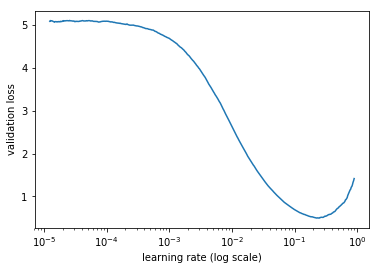

In [29]:
lrf = learn.lr_find()
learn.sched.plot()

In [30]:
# decide how many epochs it takes for the learning rate to fall to
# its minimum point. In this case, 1 epoch





learn.fit(lrs = 0.01, n_cycle = 3)

epoch      trn_loss   val_loss   accuracy   
    0      0.135266   0.132034   0.965843  
    1      0.066843   0.095327   0.970455  
    2      0.049313   0.085911   0.972833  


[array([0.08591]), 0.9728327448295742]

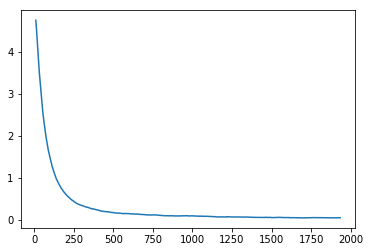

In [31]:
learn.sched.plot_loss()

## Increase Size

In [35]:
# Starting training on small images for a few epochs, then switching to bigger images,
# and continuing training is an amazingly effective way to avoid overfitting.
# set_data doesn’t change the model at all. It just gives it new data to train with.

learn.set_data(get_data(300))
learn.freeze()

In [36]:
learn.fit(lrs = 0.01,
          n_cycle = 3,
          cycle_len = 1,
          cycle_mult = 2)

epoch      trn_loss   val_loss   accuracy   
    0      0.039348   0.080927   0.973481  
    1      0.032093   0.070501   0.975571  
    2      0.030827   0.071813   0.975283  
    3      0.029113   0.072919   0.975715  
    4      0.031026   0.0697     0.975211  
    5      0.023038   0.068932   0.975139  
    6      0.020998   0.065226   0.976796  


[array([0.06523]), 0.9767961374936946]

In [37]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9767961374936946, 0.06530638954261969)

In [38]:
learn.save('300_pre')

In [39]:
learn.load('300_pre')

In [40]:
learn.fit(lrs = 0.01,
          n_cycle = 1,
          cycle_len = 2)

epoch      trn_loss   val_loss   accuracy   
    0      0.019175   0.065801   0.976724  
    1      0.023858   0.065129   0.976796  


[array([0.06513]), 0.9767961374936946]

In [41]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9767961374936946, 0.06516138282224149)

## Other Architectures

 - **VGG**: vgg16, vgg19
 - **Resnet**: resnet18, resnet50, resnet101, resnet152
 - **Resnext**: resnext50, resnext101, resnext101_64
 - **Densenet**: dn121, dn161, dn169, dn201
 - **Other**: wrn, inceptionresnet_2, inception_4

In [34]:
def train_and_optimize(architecture):
    data = get_data(224)
    sz = 64
    
    print('===== RESIZING DATA =====')
    data = data.resize(int(sz * 1.3), '/tmp')
    
    # init model
    learn = ConvLearner.pretrained(f = arch, data = data, precompute = True)
    
    # init train
    print('\n\n===== TRAIN MODEL =====')
    learn.fit(lrs = 0.01, n_cycle = 3)
    
    # optimze, larger images
    print('\n\n===== TRAIN MODEL WITH LARGER IMAGES =====')
    learn.set_data(get_data(300))
    learn.freeze()
    learn.fit(lrs = 0.01, n_cycle = 3, cycle_len = 1, cycle_mult = 2)
    log_preds, y = learn.TTA()
    probs = np.mean(np.exp(log_preds),0)
    print('Accuracy:', accuracy_np(probs, y))
    
    # optimize again
    print('\n\n===== LAST OPTIMIZATION =====')
    learn.fit(lrs = 0.01, n_cycle = 1, cycle_len = 2)
    log_preds, y = learn.TTA()
    probs = np.mean(np.exp(log_preds),0)
    
    print('\nFinal Accuracy:', accuracy_np(probs, y), '\n')

### VGG-16

In [35]:
train_and_optimize(vgg16)

===== RESIZING DATA =====




===== TRAIN MODEL =====


epoch      trn_loss   val_loss   accuracy   
    0      0.133402   0.127126   0.966131  
    1      0.065504   0.090019   0.97168   
    2      0.050597   0.080329   0.971319  


===== TRAIN MODEL WITH LARGER IMAGES =====


epoch      trn_loss   val_loss   accuracy   
    0      0.040172   0.07523    0.974995  
    1      0.033926   0.071724   0.975355  
    2      0.029786   0.070937   0.976148  
    3      0.026597   0.073024   0.975499  
    4      0.024385   0.063921   0.97694   
    5      0.025517   0.060516   0.977301  
    6      0.022304   0.061882   0.977229  
Accuracy: 0.9772285076025078


===== LAST OPTIMIZATION =====


epoch      trn_loss   val_loss   accuracy   
    0      0.023383   0.060958   0.978598  
    1      0.019354   0.060486   0.977877  
                                             
Final Accuracy: 0.9778770627657275 



### VGG-19

In [37]:
train_and_optimize(vgg19)

===== RESIZING DATA =====




===== TRAIN MODEL =====


epoch      trn_loss   val_loss   accuracy   
    0      0.138854   0.127463   0.968581  
    1      0.071779   0.090844   0.973193  
    2      0.045648   0.076045   0.974706  


===== TRAIN MODEL WITH LARGER IMAGES =====


epoch      trn_loss   val_loss   accuracy   
    0      0.039558   0.075687   0.975427  
    1      0.034471   0.067309   0.977661  
    2      0.031119   0.066794   0.977084  
    3      0.026031   0.069116   0.977445  
    4      0.027016   0.065516   0.977949  
    5      0.027494   0.059626   0.979174  
    6      0.023984   0.059822   0.97903   
Accuracy: 0.9790300497225625


===== LAST OPTIMIZATION =====


epoch      trn_loss   val_loss   accuracy   
    0      0.023295   0.062543   0.979318  
    1      0.02213    0.063882   0.977877  
                                             
Final Accuracy: 0.9778770627657275 



### ResNet-18

In [39]:
train_and_optimize(resnet18)

===== RESIZING DATA =====




===== TRAIN MODEL =====


epoch      trn_loss   val_loss   accuracy   
    0      0.127919   0.126371   0.972112  
    1      0.073398   0.08354    0.975571  
    2      0.047434   0.077308   0.975283  


===== TRAIN MODEL WITH LARGER IMAGES =====


epoch      trn_loss   val_loss   accuracy   
    0      0.038393   0.07059    0.977805  
    1      0.035521   0.065761   0.977733  
    2      0.029547   0.064233   0.978165  
    3      0.027559   0.061135   0.980039  
    4      0.021693   0.061398   0.977949  
    5      0.022715   0.060152   0.978886  
    6      0.021456   0.060271   0.978742  
Accuracy: 0.9787418029833538


===== LAST OPTIMIZATION =====


epoch      trn_loss   val_loss   accuracy   
    0      0.022682   0.058235   0.978958  
    1      0.02267    0.057463   0.979174  
                                             
Final Accuracy: 0.9791741730921669 



### ResNet-50

In [41]:
train_and_optimize(resnet50)

===== RESIZING DATA =====




===== TRAIN MODEL =====


epoch      trn_loss   val_loss   accuracy   
    0      0.128424   0.119509   0.968653  
    1      0.068936   0.087211   0.974923  
    2      0.043925   0.071474   0.977156  


===== TRAIN MODEL WITH LARGER IMAGES =====


epoch      trn_loss   val_loss   accuracy   
    0      0.036163   0.066907   0.977949  
    1      0.033562   0.066294   0.978381  
    2      0.029893   0.063109   0.979174  
    3      0.027983   0.061177   0.978742  
    4      0.029022   0.057338   0.980615  
    5      0.029232   0.054618   0.981408  
    6      0.023594   0.056808   0.980615  
Accuracy: 0.9807595301578151


===== LAST OPTIMIZATION =====


epoch      trn_loss   val_loss   accuracy   
    0      0.023973   0.054435   0.981048  
    1      0.022104   0.053344   0.981552  
                                             
Final Accuracy: 0.9815522086906392 



### ResNet-101

In [43]:
train_and_optimize(resnet101)

===== RESIZING DATA =====




===== TRAIN MODEL =====


epoch      trn_loss   val_loss   accuracy   
    0      0.129648   0.120728   0.971319  
    1      0.066577   0.087397   0.975499  
    2      0.053305   0.067844   0.979607  


===== TRAIN MODEL WITH LARGER IMAGES =====


epoch      trn_loss   val_loss   accuracy   
    0      0.049343   0.067803   0.978742  
    1      0.030767   0.0625     0.97867   
    2      0.036252   0.061396   0.979751  
    3      0.028076   0.05791    0.98076   
    4      0.029879   0.055432   0.98148   
    5      0.023298   0.057666   0.980399  
    6      0.021953   0.057609   0.980255  
Accuracy: 0.9802550983641998


===== LAST OPTIMIZATION =====


epoch      trn_loss   val_loss   accuracy   
    0      0.021819   0.053869   0.98112   
    1      0.023081   0.052217   0.981768  
                                             
Final Accuracy: 0.981840455429848 



### ResNeXt-50

In [45]:
train_and_optimize(resnext50)

===== RESIZING DATA =====




===== TRAIN MODEL =====


epoch      trn_loss   val_loss   accuracy   
    0      0.132473   0.114732   0.969086  
    1      0.066308   0.091975   0.971319  
    2      0.044682   0.070434   0.976148  


===== TRAIN MODEL WITH LARGER IMAGES =====


epoch      trn_loss   val_loss   accuracy   
    0      0.043447   0.068654   0.976003  
    1      0.031894   0.063517   0.976724  
    2      0.031141   0.063664   0.976292  
    3      0.028789   0.061428   0.978526  
    4      0.027527   0.057374   0.978742  
    5      0.022067   0.057864   0.978598  
    6      0.024731   0.057109   0.978958  
Accuracy: 0.9789579880377604


===== LAST OPTIMIZATION =====


epoch      trn_loss   val_loss   accuracy   
    0      0.02519    0.060132   0.978093  
    1      0.023435   0.05945    0.978958  
                                             
Final Accuracy: 0.9790300497225625 



### ResNeXt-101

In [47]:
train_and_optimize(resnext101)

===== RESIZING DATA =====




===== TRAIN MODEL =====


epoch      trn_loss   val_loss   accuracy   
    0      0.123601   0.123497   0.969518  
    1      0.063954   0.093815   0.97204   
    2      0.045928   0.07837    0.97377   


===== TRAIN MODEL WITH LARGER IMAGES =====


epoch      trn_loss   val_loss   accuracy   
    0      0.040028   0.071148   0.976292  
    1      0.036975   0.072645   0.97658   
    2      0.030924   0.066787   0.976724  
    3      0.026336   0.060109   0.979751  
    4      0.027712   0.057249   0.980255  
    5      0.02604    0.060402   0.979462  
    6      0.024311   0.060428   0.980183  
Accuracy: 0.9801830366793975


===== LAST OPTIMIZATION =====


epoch      trn_loss   val_loss   accuracy   
    0      0.025171   0.058227   0.980471  
    1      0.021045   0.058353   0.980111  
                                             
Final Accuracy: 0.9801109749945953 



### ResNeXt-101 (64)

In [49]:
train_and_optimize(resnext101_64)

===== RESIZING DATA =====




===== TRAIN MODEL =====


epoch      trn_loss   val_loss   accuracy   
    0      0.126905   0.125414   0.967428  
    1      0.069327   0.085581   0.973337  
    2      0.048726   0.076104   0.975499  


===== TRAIN MODEL WITH LARGER IMAGES =====


epoch      trn_loss   val_loss   accuracy   
    0      0.03899    0.074632   0.975355  
    1      0.035619   0.066053   0.978309  
    2      0.031498   0.063518   0.978021  
    3      0.027512   0.066551   0.978814  
    4      0.022714   0.058192   0.980111  
    5      0.025765   0.061481   0.979174  
    6      0.032112   0.059373   0.980327  
Accuracy: 0.9803992217338041


===== LAST OPTIMIZATION =====


epoch      trn_loss   val_loss   accuracy   
    0      0.022716   0.060681   0.979823  
    1      0.020867   0.055556   0.980327  
                                             
Final Accuracy: 0.980327160049002 



### DenseNet-121

In [51]:
train_and_optimize(dn121)

===== RESIZING DATA =====




===== TRAIN MODEL =====


epoch      trn_loss   val_loss   accuracy   
    0      0.133051   0.124835   0.970311  
    1      0.068309   0.092548   0.971896  
    2      0.045681   0.079585   0.973842  


===== TRAIN MODEL WITH LARGER IMAGES =====


epoch      trn_loss   val_loss   accuracy   
    0      0.03928    0.075875   0.974706  
    1      0.034492   0.072366   0.974562  
    2      0.032686   0.07068    0.975355  
    3      0.028301   0.070212   0.97622   
    4      0.025583   0.062592   0.978309  
    5      0.02663    0.071963   0.975715  
    6      0.023432   0.066186   0.976652  
Accuracy: 0.9766520141240902


===== LAST OPTIMIZATION =====


epoch      trn_loss   val_loss   accuracy   
    0      0.023918   0.064502   0.976652  
    1      0.020205   0.066293   0.976508  
                                             
Final Accuracy: 0.9765078907544859 



### DenseNet-161

In [53]:
train_and_optimize(dn161)

===== RESIZING DATA =====




===== TRAIN MODEL =====


epoch      trn_loss   val_loss   accuracy   
    0      0.130069   0.126433   0.968941  
    1      0.065961   0.092299   0.975283  
    2      0.046145   0.077524   0.97413   


===== TRAIN MODEL WITH LARGER IMAGES =====


epoch      trn_loss   val_loss   accuracy   
    0      0.036151   0.076131   0.97622   
    1      0.035207   0.071295   0.976364  
    2      0.032365   0.073192   0.97622   
    3      0.029423   0.069711   0.976436  
    4      0.026179   0.069046   0.976652  
    5      0.025633   0.069175   0.976796  
    6      0.022666   0.068606   0.977012  
Accuracy: 0.9770123225481012


===== LAST OPTIMIZATION =====


epoch      trn_loss   val_loss   accuracy   
    0      0.022547   0.070219   0.976364  
    1      0.022258   0.06499    0.977156  
                                             
Final Accuracy: 0.9771564459177056 



### DenseNet-169

In [55]:
train_and_optimize(dn169)

===== RESIZING DATA =====




===== TRAIN MODEL =====


epoch      trn_loss   val_loss   accuracy   
    0      0.132657   0.117835   0.970383  
    1      0.071228   0.086962   0.974274  
    2      0.049216   0.073701   0.976652  


===== TRAIN MODEL WITH LARGER IMAGES =====


epoch      trn_loss   val_loss   accuracy   
    0      0.040643   0.07214    0.975643  
    1      0.031487   0.065186   0.978598  
    2      0.033643   0.065302   0.977949  
    3      0.028923   0.064226   0.978742  
    4      0.025334   0.058265   0.979462  
    5      0.022893   0.059829   0.978958  
    6      0.026923   0.058922   0.979823  
Accuracy: 0.9798947899401887


===== LAST OPTIMIZATION =====


epoch      trn_loss   val_loss   accuracy   
    0      0.027018   0.058663   0.979751  
    1      0.023252   0.060479   0.979246  
                                             
Final Accuracy: 0.9793182964617713 



### DenseNet-201

In [57]:
train_and_optimize(dn201)

===== RESIZING DATA =====




===== TRAIN MODEL =====


epoch      trn_loss   val_loss   accuracy   
    0      0.129984   0.121944   0.968653  
    1      0.070888   0.091456   0.972256  
    2      0.046643   0.075461   0.975355  


===== TRAIN MODEL WITH LARGER IMAGES =====


epoch      trn_loss   val_loss   accuracy   
    0      0.042583   0.071682   0.975643  
    1      0.039764   0.069261   0.976652  
    2      0.030097   0.066658   0.976868  
    3      0.032517   0.067899   0.976868  
    4      0.024931   0.061552   0.97867   
    5      0.023765   0.059588   0.978958  
    6      0.024132   0.062345   0.978021  
Accuracy: 0.9780211861353318


===== LAST OPTIMIZATION =====


epoch      trn_loss   val_loss   accuracy   
    0      0.027005   0.0629     0.978093  
    1      0.023557   0.061257   0.978814  
                                             
Final Accuracy: 0.9788859263529581 



### WRN

In [59]:
train_and_optimize(wrn)

===== RESIZING DATA =====




===== TRAIN MODEL =====


epoch      trn_loss   val_loss   accuracy   
    0      0.130171   0.124691   0.968221  
    1      0.060065   0.091866   0.974346  
    2      0.046622   0.069878   0.978814  


===== TRAIN MODEL WITH LARGER IMAGES =====


epoch      trn_loss   val_loss   accuracy   
    0      0.035313   0.071067   0.977229  
    1      0.033319   0.066811   0.978381  
    2      0.03324    0.06634    0.978598  
    3      0.032697   0.066464   0.977084  
    4      0.024343   0.063026   0.977733  
    5      0.024774   0.061639   0.978814  
    6      0.021754   0.060385   0.978742  
Accuracy: 0.9787418029833538


===== LAST OPTIMIZATION =====


epoch      trn_loss   val_loss   accuracy   
    0      0.023065   0.061247   0.978454  
    1      0.023451   0.062575   0.978814  
                                             
Final Accuracy: 0.9789579880377604 



### Inception ResNet v2

In [61]:
train_and_optimize(inceptionresnet_2)

===== RESIZING DATA =====




===== TRAIN MODEL =====


epoch      trn_loss   val_loss   accuracy   
    0      0.123538   0.122619   0.969086  
    1      0.059565   0.090222   0.97485   
    2      0.044765   0.075376   0.977012  


===== TRAIN MODEL WITH LARGER IMAGES =====


epoch      trn_loss   val_loss   accuracy   
    0      0.040438   0.07688    0.976508  
    1      0.031566   0.067427   0.979174  
    2      0.028845   0.068464   0.977949  
    3      0.028484   0.069013   0.977301  
    4      0.025213   0.067224   0.978454  
    5      0.026003   0.062603   0.979607  
    6      0.020512   0.064074   0.979246  
Accuracy: 0.979246234776969


===== LAST OPTIMIZATION =====


epoch      trn_loss   val_loss   accuracy   
    0      0.021674   0.066148   0.978381  
    1      0.020161   0.064629   0.978093  
                                             
Final Accuracy: 0.9780932478201341 



### Inception v4

In [63]:
train_and_optimize(inception_4)

===== RESIZING DATA =====




===== TRAIN MODEL =====


epoch      trn_loss   val_loss   accuracy   
    0      0.133613   0.124314   0.968005  
    1      0.062855   0.089443   0.973553  
    2      0.050996   0.081126   0.974995  


===== TRAIN MODEL WITH LARGER IMAGES =====


epoch      trn_loss   val_loss   accuracy   
    0      0.03919    0.074661   0.976508  
    1      0.035969   0.067986   0.978814  
    2      0.033559   0.068111   0.978454  
    3      0.03199    0.063309   0.978598  
    4      0.024808   0.065589   0.978021  
    5      0.026958   0.065322   0.978165  
    6      0.022788   0.063533   0.97867   
Accuracy: 0.9787418029833538


===== LAST OPTIMIZATION =====


epoch      trn_loss   val_loss   accuracy   
    0      0.026016   0.063963   0.978814  
    1      0.022354   0.060259   0.979246  
                                             
Final Accuracy: 0.979246234776969 



### ResNet-152

In [64]:
train_and_optimize(resnet152)

===== RESIZING DATA =====




===== TRAIN MODEL =====


epoch      trn_loss   val_loss   accuracy   
    0      0.135087   0.131804   0.966203  
    1      0.066964   0.091762   0.971752  
    2      0.046037   0.078712   0.974562  


===== TRAIN MODEL WITH LARGER IMAGES =====


epoch      trn_loss   val_loss   accuracy   
    0      0.042993   0.067906   0.977084  
    1      0.034606   0.068561   0.976508  
    2      0.035145   0.067817   0.977661  
    3      0.029042   0.064637   0.977805  
    4      0.024455   0.063079   0.977949  
    5      0.025621   0.062289   0.977733  
    6      0.027552   0.05932    0.978958  
Accuracy: 0.9789579880377604


===== LAST OPTIMIZATION =====


epoch      trn_loss   val_loss   accuracy   
    0      0.024151   0.057077   0.979751  
    1      0.024096   0.056866   0.97939   
                                             
Final Accuracy: 0.9794624198313756 



## Architecture Performance Summary

In [82]:
perf_summary = pd.DataFrame([
    {'Architecture': 'VGG-16', 'Train Loss': 0.019354, 'Validation Loss': 0.060486, 'Accuracy': 0.977877},
    {'Architecture': 'VGG-19', 'Train Loss': 0.02213, 'Validation Loss': 0.063882, 'Accuracy': 0.977877},
    {'Architecture': 'ResNet-18', 'Train Loss': 0.02267, 'Validation Loss': 0.057463, 'Accuracy': 0.979174},
    {'Architecture': 'ResNet-34', 'Train Loss': 0.023858, 'Validation Loss': 0.065129, 'Accuracy': 0.976796},
    {'Architecture': 'ResNet-50', 'Train Loss': 0.022104, 'Validation Loss': 0.053344, 'Accuracy': 0.981552},
    {'Architecture': 'ResNet-101', 'Train Loss': 0.023081, 'Validation Loss': 0.052217, 'Accuracy': 0.981768},
    {'Architecture': 'ResNet-152', 'Train Loss': 0.024096, 'Validation Loss': 0.056866, 'Accuracy': 0.97939},
    {'Architecture': 'ResNeXt-50', 'Train Loss': 0.023435, 'Validation Loss': 0.05945, 'Accuracy': 0.978958},
    {'Architecture': 'ResNeXt-101 (32)', 'Train Loss': 0.021045, 'Validation Loss': 0.058353, 'Accuracy': 0.980111},
    {'Architecture': 'ResNeXt-101 (64)', 'Train Loss': 0.020867, 'Validation Loss': 0.055556, 'Accuracy': 0.980327},
    {'Architecture': 'DenseNet121', 'Train Loss': 0.020205, 'Validation Loss': 0.066293, 'Accuracy': 0.976508},
    {'Architecture': 'DenseNet161', 'Train Loss': 0.022258, 'Validation Loss': 0.06499, 'Accuracy': 0.977156},
    {'Architecture': 'DenseNet169', 'Train Loss': 0.023252, 'Validation Loss': 0.060479, 'Accuracy': 0.979246},
    {'Architecture': 'DenseNet201', 'Train Loss': 0.023557, 'Validation Loss': 0.061257, 'Accuracy': 0.978814},
    {'Architecture': 'WRN', 'Train Loss': 0.023451, 'Validation Loss': 0.062575, 'Accuracy': 0.978814},
    {'Architecture': 'Inception-ResNet v2', 'Train Loss': 0.020161, 'Validation Loss': 0.064629, 'Accuracy': 0.978093},
    {'Architecture': 'Inception v4', 'Train Loss': 0.022354, 'Validation Loss': 0.060259, 'Accuracy': 0.979246}
])

In [83]:
perf_summary.index = perf_summary.Architecture
perf_summary = perf_summary.drop('Architecture', axis = 1)
perf_summary.sort_values('Accuracy', ascending = False)

,Accuracy,Train Loss,Validation Loss
Architecture,,,
ResNet-101,0.981768,0.023081,0.052217
ResNet-50,0.981552,0.022104,0.053344
ResNeXt-101 (64),0.980327,0.020867,0.055556
ResNeXt-101 (32),0.980111,0.021045,0.058353
ResNet-152,0.979390,0.024096,0.056866
DenseNet169,0.979246,0.023252,0.060479
Inception v4,0.979246,0.022354,0.060259
ResNet-18,0.979174,0.022670,0.057463
ResNeXt-50,0.978958,0.023435,0.059450


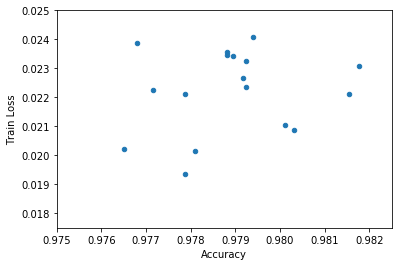

In [84]:
perf_summary.plot(x = 'Accuracy', y = 'Train Loss', kind = 'scatter',
                  xlim = (0.975, 0.9825), ylim = (0.0175, 0.025)
                 );

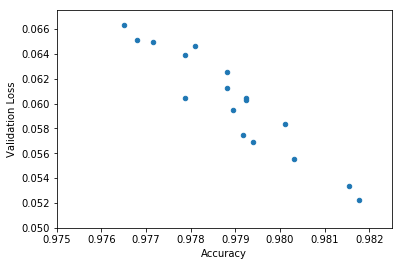

In [85]:
perf_summary.plot(x = 'Accuracy', y = 'Validation Loss', kind = 'scatter',
                  xlim = (0.975, 0.9825), ylim = (0.05, 0.0675)
                 );

## Further Optimizations

In [4]:
data = get_data(224)
sz = 64

data = data.resize(int(sz * 1.3), '/tmp')

# init model
learn = ConvLearner.pretrained(f = resnet101, data = data, precompute = True)

In [5]:
# init train
learn.fit(lrs = 0.01, n_cycle = 3)

epoch      trn_loss   val_loss   accuracy   
    0      0.060093   0.0894     0.974706  
    1      0.032856   0.067015   0.979967  
    2      0.019797   0.056702   0.980904  



[array([0.0567]), 0.9809036535274195]

In [6]:
# unfreeze the network and use differential lrs to slightly optimize the earlier layer groups
learn.unfreeze()
#learn.bn_freeze() <-- DID NOT DO THIS, BUT MAYBE SHOULD
lrs = np.array([1e-4, 1e-3, 1e-2])

# fit whole model with differential learning rates, restarts, lr cosine annealing
learn.fit(lrs,
          n_cycle = 3,     # number of restarts
          cycle_len = 1,   # init number of epochs to reach lowest lr (as deter. by cosine annealing)
          cycle_mult = 2   # multiplier of cycle len after each cycle
         )                 # in this case: cycle 1: 1 epoch, cycle 2: 2 epochs, cycle 3: 4 epochs

epoch      trn_loss   val_loss   accuracy   
    0      0.085409   0.053716   0.979751  
    1      0.057685   0.047283   0.982777  
    2      0.044184   0.046884   0.98112   
    3      0.042161   0.04315    0.982417  
    4      0.030323   0.039698   0.985227  
    5      0.03026    0.036925   0.986741  
    6      0.029818   0.037711   0.985444  



[array([0.03771]), 0.9854435396699575]

In [19]:
learn.save('/floyd/home/models/resnet101_optim_1')

In [7]:
data = get_data(224)
sz = 64

data = data.resize(int(sz * 1.3), '/tmp')

# init model
learn = ConvLearner.pretrained(f = resnet101, data = data)#, precompute = True)

In [8]:
learn.load('/floyd/home/models/resnet101_optim_1')

In [12]:
sz*=2

# fit final layer with larger images
learn.set_data(get_data(sz))
learn.freeze()

In [14]:
learn.fit(lrs = 0.01, n_cycle = 3, cycle_len = 1, cycle_mult = 2)

epoch      trn_loss   val_loss   accuracy   
    0      0.072596   0.063141   0.978886  
    1      0.048897   0.051128   0.980904  
    2      0.038284   0.045813   0.983714  
    3      0.033814   0.04828    0.980615  
    4      0.028535   0.044673   0.984074  
    5      0.028105   0.041427   0.984363  
    6      0.025426   0.040234   0.984939  



[array([0.04023]), 0.9849391078763422]

In [15]:
learn.save('/floyd/home/models/resnet101_optim_2')

In [18]:
learn.load('/floyd/home/models/resnet101_optim_2')

In [19]:
learn.unfreeze()
learn.fit(lrs, n_cycle = 3, cycle_len = 1, cycle_mult = 2, best_save_name='resnet101_optim_best')

epoch      trn_loss   val_loss   accuracy   
    0      0.02213    0.029737   0.987822  
    1      0.014585   0.024609   0.989191  
    2      0.014233   0.02637    0.988975  
    3      0.009572   0.024995   0.989839  
    4      0.011934   0.025427   0.990128  
    5      0.011239   0.02511    0.989839  
    6      0.012425   0.024528   0.989983  



[array([0.02453]), 0.9899834258124955]

In [22]:
learn.save('/floyd/home/models/resnet101_optim_3')

In [23]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
print('Accuracy:', accuracy_np(probs, y))

Accuracy: 0.9903437342365065


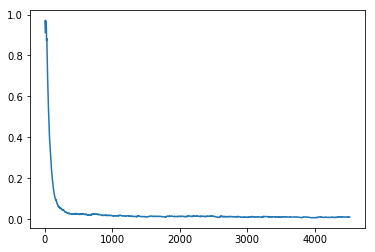

In [24]:
learn.sched.plot_loss()

In [29]:
learn.load('resnet101_optim_best')

In [30]:
sz*=2

# fit final layer with larger images
learn.set_data(get_data(sz))
learn.freeze()

learn.fit(0.01, n_cycle = 3, cycle_len = 1, cycle_mult = 2, best_save_name='/floyd/home/models/resnet101_optim_best_2')

epoch      trn_loss   val_loss   accuracy   
    0      0.031001   0.021974   0.98883   
    1      0.020801   0.02177    0.988975  
    2      0.024431   0.020929   0.988903  
    3      0.02065    0.019331   0.990344  
    4      0.016477   0.018891   0.989623  
    5      0.016007   0.019088   0.989695  
    6      0.01501    0.019417   0.989623  


[array([0.01942]), 0.9896231173884845]

In [31]:
learn.save('/floyd/home/models/resnet101_optim_4')

In [34]:
learn.load('/floyd/home/models/resnet101_optim_best_2')

In [35]:
learn.unfreeze()
learn.fit(lrs, n_cycle = 3, cycle_len = 1, cycle_mult = 2, best_save_name='/floyd/home/models/resnet101_optim_best_3')

epoch      trn_loss   val_loss   accuracy   
    0      0.013142   0.017849   0.990632  
    1      0.011643   0.021521   0.989695  
    2      0.011658   0.019389   0.99092   
    3      0.011299   0.02022    0.990776  
    4      0.009914   0.021156   0.990776  
    5      0.007739   0.020686   0.99092   
    6      0.009444   0.020471   0.991064  


[array([0.02047]), 0.9910643510845284]

In [ ]:
learn.save('/floyd/home/models/resnet101_optim_5')

In [8]:
learn = load_model_new_kernel('/floyd/home/models/resnet101_optim_best_3')

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.torch/models/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:08<00:00, 20973285.48it/s]


In [11]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
print('\nFinal Accuracy:', accuracy_np(probs, y), '\n')

                                              
Final Accuracy: 0.9842184910283203 



In [12]:
print('done!')

done!
